In [54]:
import urllib2
import json
import datetime
import time
import threading
import timeit
import pandas as pd
import cPickle as pk
from time import strftime,strptime,gmtime
import datetime

import numpy as np
import scipy as sp

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Visualization libraries
# Displays plots in output cell
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, cross_validation
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

In [55]:
def positive_negative (v):
    if v >= 0:
        return 1
    else: 
        return 0 

In [238]:
def learning_downloader (stock_list,days = 500,shift_days = 10):
    #date variables
    dt = datetime.datetime.now()
    UnixTime = int(time.mktime(dt.timetuple()))
    data_df = pd.DataFrame()
    for s in stock_list:
        #web variables
        url = 'https://query1.finance.yahoo.com/v8/finance/chart/'+s+'?period1='+str(UnixTime-86400*days)+'&period2='+str(UnixTime)+'&interval=1d&indicators=quote%7Csma~50&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-CA&region=CA&corsDomain=ca.finance.yahoo.com'
        hdr = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.101 Safari/537.36',
               'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
               'Connection': 'keep-alive'}
        #html data request 
        try:
            request = urllib2.Request(url,headers = hdr)
            htmltext = urllib2.urlopen(request)
        
            data = json.load(htmltext)
            #json unpack
            timestamp = data['chart']['result'][0]['timestamp']
            timestamp = [datetime.datetime.fromtimestamp(x).strftime('%Y%m%d') for x in timestamp]
            quote = data['chart']['result'][0]['indicators']['quote'][0]
            sma50 = data['chart']['result'][0]['indicators']['sma'][0]['sma']
            stock_df = pd.DataFrame(quote)
            #index is symbol and timestamp
            stock_df.index = [s + str(x) for x in timestamp]

            #moving averages
            stock_df['sma'] = sma50
            stock_df['vol20'] = stock_df['volume'].rolling(window=20).mean()
            stock_df = stock_df.dropna()

            #derived columns
            stock_df['c_0'] = stock_df['close']/stock_df['sma']
            stock_df['h_0'] = stock_df['high']/stock_df['sma']
            stock_df['l_0'] = stock_df['low']/stock_df['sma']
            stock_df['o_0'] = stock_df['open']/stock_df['sma']
            stock_df['v_0'] = stock_df['volume']/stock_df['vol20']
            stock_df['r'] = (stock_df['close']-stock_df['open'])/stock_df['open']

            #rolling columns
            for d in list(range(1,shift_days+1)):
                stock_df['c_'+str(d)] = stock_df['c_0'].shift(d)
                stock_df['h_'+str(d)] = stock_df['h_0'].shift(d)
                stock_df['l_'+str(d)] = stock_df['l_0'].shift(d)
                stock_df['o_'+str(d)] = stock_df['o_0'].shift(d)
                stock_df['v_'+str(d)] = stock_df['v_0'].shift(d)
            stock_df.drop(['close', 'high', 'low', 'open','volume','sma','vol20'], axis=1, inplace=True)
            stock_df = stock_df.dropna()

            #add to main df 
            if len(data_df) == 0:
                data_df = stock_df
            elif timestamp is None : 
                pass
            else:
                data_df = data_df.append(stock_df)
            
        except:
            pass
            
    data_df = data_df.dropna()
    return data_df
        

In [239]:
#download learning data from list of stocks
stock_list = ['AA', 'ABT', 'ABX', 'ADI', 'ADM', 'AET', 'AMD', 'AMR', 'APC', 'AVP', 'AXP', 'BA', 'BAC', 'BAX', 'BBY', 'BK', 'BMC', 'BMY', 'BNI', 'BP', 'CA', 'CAT', 'CI', 'CL', 'COP', 'CVX', 'DD', 'DE', 'DIS', 'DOW', 'EK', 'EMC', 'EMR', 'FNM', 'FRE', 'FRX', 'GE', 'GLW', 'GPS', 'GSK', 'HAL', 'HD', 'HON', 'HPQ', 'HRB', 'IBM', 'IGT', 'JNJ', 'JPM', 'JWN', 'KO', 'KR', 'LLY', 'LOW', 'LTD', 'LUV', 'MCD', 'MDT', 'MMM', 'MO', 'MOT', 'MRK', 'MRO', 'MU', 'MYL', 'NKE', 'NSM', 'NWS', 'OXY', 'PEP', 'PFE', 'PG', 'RSH', 'SLB', 'SLE', 'SLM', 'STJ', 'SYK', 'SYY', 'TGT', 'TJX', 'TMX', 'TXN', 'UN', 'UNH', 'UTX', 'VOD', 'VZ', 'WAG', 'WFC', 'WMB', 'WMT', 'XOM', 'XRX']
#stock_list = ['^GDAXI','^FTSE','^DJI','^FCHI','^N225','^HSI','^AXJO','^GSPC','^IXIC','^TNX','^VIX']
ml_df = learning_downloader(stock_list)
#not making decision on intraday close high low and volumes 
ml_df = ml_df.drop(['c_0','v_0'], axis=1)
#ml_df['r'] = ml_df['r'].map(positive_negative)

In [243]:
#learning data prep
X = np.array(ml_df.drop(['r'],1))
y = np.array(ml_df['r'])
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size= 0.2)

In [244]:
#Gradiant Boosting Ensemble
clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train,y_train)
print clf.score(X_test, y_test)
clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X,y)

0.377018749166


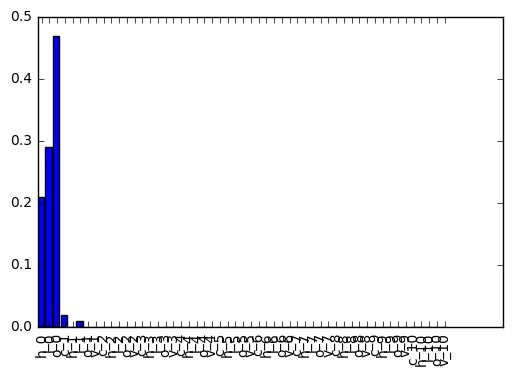

In [245]:
feature_names = ml_df.drop(['r'],1).columns.values
x = np.arange(len(feature_names))
plt.bar(x, clf.feature_importances_)
_= plt.xticks(x + 0.5, feature_names, rotation=90)

In [187]:
#def stock_predict (symbol,clf):
    